In [1]:
import numpy as np
import pandas as pd
import os
import warnings

In [2]:
from keras.models import load_model
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate, BatchNormalization, Dropout
from keras.models import Model
from keras.losses import MeanSquaredError
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import matplotlib
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
plt.rcParams['figure.figsize'] = [12,8]
plt.rc('font', size=20)          # controls default text sizes
plt.rc('axes', titlesize=24)     # fontsize of the axes title
plt.rc('axes', labelsize=24)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=15.5)    # legend fontsize
plt.rc('figure', titlesize=50)  # fontsize of the figure title

# NCF Grid Search Analysis

In [5]:
model_info_all_df = pd.read_csv('ncf_models/model_info_all.csv')

In [6]:
model_info_all_df.sort_values('test mse')

,Unnamed: 0,model,test mse,test preds std,epochs,learning rate,n_nodes_per_layer,n_factors,batch_size,dropout_prob,patience,early stopping metric
93,93,93,0.876653,6.335981e-01,250,0.010,"[64, 32, 16, 8, 4, 2]",100,256,0.2,5,val_loss
22,22,22,0.877472,5.548574e-01,250,0.001,"[512, 256, 128, 64, 32, 16, 8, 4, 2]",5,256,0.2,5,val_loss
81,81,81,0.884661,6.800390e-01,250,0.010,"[64, 32, 16, 8, 4, 2]",5,256,0.2,5,val_loss
84,84,84,0.886044,7.086098e-01,250,0.100,"[64, 32, 16, 8, 4, 2]",25,256,0.2,5,val_loss
5,5,5,0.886648,7.023544e-01,250,0.010,"[1024, 512, 256, 128, 64, 32, 16, 8, 4, 2]",25,256,0.2,5,val_loss
...,...,...,...,...,...,...,...,...,...,...,...,...
4,4,4,1.257792,0.000000e+00,250,0.100,"[1024, 512, 256, 128, 64, 32, 16, 8, 4, 2]",25,256,0.2,5,val_loss
65,65,65,1.257817,4.768372e-07,250,0.010,"[128, 64, 32, 16, 8, 4, 2]",25,256,0.2,5,val_loss
68,68,68,1.259597,7.152557e-07,250,0.100,"[128, 64, 32, 16, 8, 4, 2]",50,256,0.2,5,val_loss
80,80,80,1.261794,4.768372e-07,250,0.100,"[64, 32, 16, 8, 4, 2]",5,256,0.2,5,val_loss


The model with the lowest test MSE is Model 93.

In [7]:
ncf_single_arch_df = model_info_all_df[model_info_all_df['n_nodes_per_layer'] == '[64, 32, 16, 8, 4, 2]']

In [8]:
ncf_single_arch_df.sort_values('n_factors')

,Unnamed: 0,model,test mse,test preds std,epochs,learning rate,n_nodes_per_layer,n_factors,batch_size,dropout_prob,patience,early stopping metric
80,80,80,1.261794,4.768372e-07,250,0.1000,"[64, 32, 16, 8, 4, 2]",5,256,0.2,5,val_loss
81,81,81,0.884661,6.800390e-01,250,0.0100,"[64, 32, 16, 8, 4, 2]",5,256,0.2,5,val_loss
82,82,82,0.985691,4.056911e-01,250,0.0010,"[64, 32, 16, 8, 4, 2]",5,256,0.2,5,val_loss
83,83,83,0.908053,6.346143e-01,250,0.0001,"[64, 32, 16, 8, 4, 2]",5,256,0.2,5,val_loss
84,84,84,0.886044,7.086098e-01,250,0.1000,"[64, 32, 16, 8, 4, 2]",25,256,0.2,5,val_loss
85,85,85,0.919166,7.469037e-01,250,0.0100,"[64, 32, 16, 8, 4, 2]",25,256,0.2,5,val_loss
86,86,86,1.262006,7.074481e-02,250,0.0010,"[64, 32, 16, 8, 4, 2]",25,256,0.2,5,val_loss
87,87,87,0.917806,5.063339e-01,250,0.0001,"[64, 32, 16, 8, 4, 2]",25,256,0.2,5,val_loss
91,91,91,0.903808,6.061627e-01,250,0.0001,"[64, 32, 16, 8, 4, 2]",50,256,0.2,5,val_loss
90,90,90,0.916721,6.592742e-01,250,0.0010,"[64, 32, 16, 8, 4, 2]",50,256,0.2,5,val_loss


In [9]:
n_factors_list = [5, 25, 50, 100, 200]
factors_5_mse_all_list = []
factors_25_mse_all_list = []
factors_50_mse_all_list = []
factors_100_mse_all_list = []
factors_200_mse_all_list = []

factors_5_mse_all_list = list(ncf_single_arch_df[ncf_single_arch_df.n_factors == 5].sort_values('learning rate')['test mse'])
factors_25_mse_all_list = list(ncf_single_arch_df[ncf_single_arch_df.n_factors  == 25].sort_values('learning rate')['test mse'])
factors_50_mse_all_list = list(ncf_single_arch_df[ncf_single_arch_df.n_factors  == 50].sort_values('learning rate')['test mse'])
factors_100_mse_all_list = list(ncf_single_arch_df[ncf_single_arch_df.n_factors  == 100].sort_values('learning rate')['test mse'])
factors_200_mse_all_list = list(ncf_single_arch_df[ncf_single_arch_df.n_factors  == 200].sort_values('learning rate')['test mse'])

factors_5_mse_all_list.reverse()
factors_25_mse_all_list.reverse()
factors_50_mse_all_list.reverse()
factors_100_mse_all_list.reverse()
factors_200_mse_all_list.reverse()

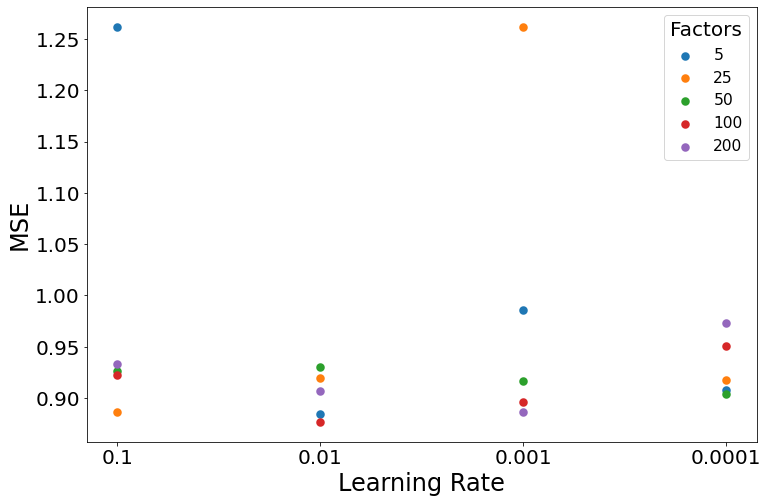

In [11]:
plt.scatter(x = [1,2,3,4], y = factors_5_mse_all_list, label = '5', linewidth = 2.5)
plt.scatter(x = [1,2,3,4], y = factors_25_mse_all_list, label = '25', linewidth = 2.5)
plt.scatter(x = [1,2,3,4], y = factors_50_mse_all_list, label = '50', linewidth = 2.5)
plt.scatter(x = [1,2,3,4], y = factors_100_mse_all_list, label = '100', linewidth = 2.5)
plt.scatter(x = [1,2,3,4], y = factors_200_mse_all_list, label = '200', linewidth = 2.5)
plt.xticks(ticks = [1,2,3,4], labels = [1e-1, 1e-2, 1e-3, 1e-4])
plt.legend(title = 'Factors')
# plt.yscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('MSE')
plt.savefig('figures/ncf_mse_vs_factors_and_lr.png',bbox_inches='tight')

# TFIDF Grid Search Analysis

In [15]:
final_result_full_tfidf_df = pd.read_csv('final_result_full_tfidf.csv')

In [16]:
final_result_full_tfidf_df

,dataset_name,sim_method,algo,sim_threshold,neighbors,sig_weight,weighting_factor,coverage,mse,rmse,mae
0,ml-100k,TFIDF,new_get_TFIDF_recommendations,0.000000,0,0,0,0.99743,1.048402,1.023915,0.816841
1,ml-100k,TFIDF,new_get_TFIDF_recommendations,0.306194,0,0,0,0.99715,1.054174,1.026730,0.818359
2,ml-100k,TFIDF,new_get_TFIDF_recommendations,0.576448,0,0,0,0.98334,1.104257,1.050836,0.829047
3,ml-100k,TFIDF,new_get_TFIDF_recommendations,0.846703,0,0,0,0.83227,1.267398,1.125788,0.863466


In [17]:
final_result_full_tfidf_df.sort_values('mse')

,dataset_name,sim_method,algo,sim_threshold,neighbors,sig_weight,weighting_factor,coverage,mse,rmse,mae
0,ml-100k,TFIDF,new_get_TFIDF_recommendations,0.000000,0,0,0,0.99743,1.048402,1.023915,0.816841
1,ml-100k,TFIDF,new_get_TFIDF_recommendations,0.306194,0,0,0,0.99715,1.054174,1.026730,0.818359
2,ml-100k,TFIDF,new_get_TFIDF_recommendations,0.576448,0,0,0,0.98334,1.104257,1.050836,0.829047
3,ml-100k,TFIDF,new_get_TFIDF_recommendations,0.846703,0,0,0,0.83227,1.267398,1.125788,0.863466


The TFIDF model with the lowest MSE/best coverage has a sim_threshold of 0. 

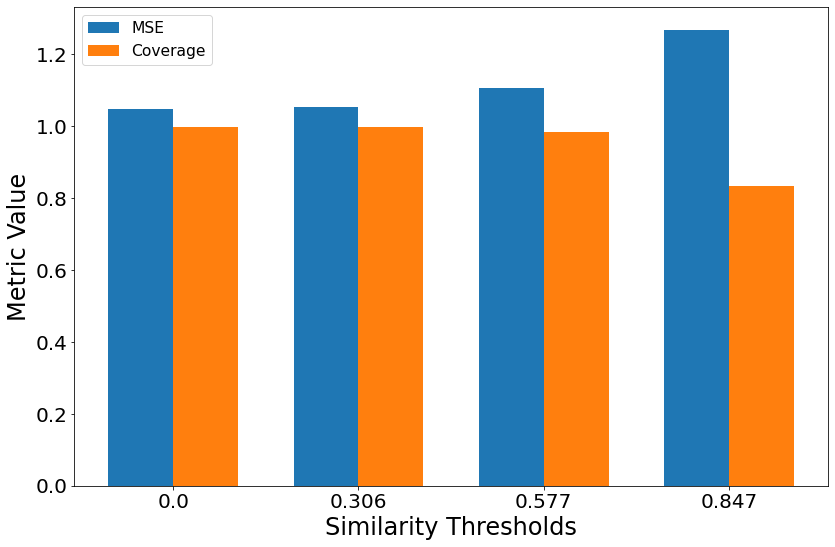

In [18]:
tfidf_sim_threshold_list = ['0.0', '0.306', '0.577', '0.847']
tfidf_mse_list = final_result_full_tfidf_df['mse']
tfidf_coverage_list = final_result_full_tfidf_df['coverage']

x = np.arange(len(tfidf_sim_threshold_list ))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, tfidf_mse_list, width, label='MSE')
rects2 = ax.bar(x + width/2, tfidf_coverage_list, width, label='Coverage')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Metric Value')
ax.set_xlabel('Similarity Thresholds')
ax.set_xticks(x, tfidf_sim_threshold_list)
ax.legend()

fig.tight_layout()

plt.savefig('figures/tfidf_grid_results.png',bbox_inches='tight')

# Hybrid Grid Search Analysis

In [25]:
final_result_full_hybrid_df = pd.read_csv('final_result_full_hybrid.csv')
final_result_full_hybrid_distance_df = final_result_full_hybrid_df[final_result_full_hybrid_df['sim_method'] == '<function sim_distance at 0x7fdf515cf700>']
final_result_full_hybrid_pearson_df = final_result_full_hybrid_df[final_result_full_hybrid_df['sim_method'] == '<function sim_pearson at 0x7fdf515cf790>']

In [26]:
final_result_full_hybrid_df.sort_values('mse')

,dataset_name,sim_method,algo,sim_threshold,neighbors,sig_weight,weighting_factor,coverage,mse,rmse,mae
7,ml-100k,<function sim_pearson at 0x7fdf515cf790>,new_get_hybrid_recommendations,0.000000,100,100,1.00,0.99955,1.001539,1.000769,0.797949
5,ml-100k,<function sim_pearson at 0x7fdf515cf790>,new_get_hybrid_recommendations,0.000000,100,100,0.75,0.99955,1.009658,1.004818,0.801366
3,ml-100k,<function sim_pearson at 0x7fdf515cf790>,new_get_hybrid_recommendations,0.000000,100,100,0.50,0.99955,1.019228,1.009568,0.805351
6,ml-100k,<function sim_distance at 0x7fdf515cf700>,new_get_hybrid_recommendations,0.000000,100,100,1.00,0.99930,1.029657,1.014720,0.809199
1,ml-100k,<function sim_pearson at 0x7fdf515cf790>,new_get_hybrid_recommendations,0.000000,100,100,0.25,0.99955,1.031056,1.015409,0.810160
4,ml-100k,<function sim_distance at 0x7fdf515cf700>,new_get_hybrid_recommendations,0.000000,100,100,0.75,0.99930,1.033208,1.016469,0.810670
2,ml-100k,<function sim_distance at 0x7fdf515cf700>,new_get_hybrid_recommendations,0.000000,100,100,0.50,0.99930,1.037195,1.018428,0.812297
15,ml-100k,<function sim_pearson at 0x7fdf515cf790>,new_get_hybrid_recommendations,0.306194,100,100,1.00,0.99756,1.038395,1.019017,0.811929
0,ml-100k,<function sim_distance at 0x7fdf515cf700>,new_get_hybrid_recommendations,0.000000,100,100,0.25,0.99930,1.041837,1.020704,0.814153
13,ml-100k,<function sim_pearson at 0x7fdf515cf790>,new_get_hybrid_recommendations,0.306194,100,100,0.75,0.99724,1.052063,1.025701,0.817443


The Hybrid-Pearson model with the lowest mse has a sim_threshold of 0, 100 neighbors, a similarity significance weighting cutoff of 100, and a weighting factor of 1. 

In [27]:
threshold_1_hybrid_distance_mse_all_list = list(final_result_full_hybrid_distance_df[final_result_full_hybrid_distance_df.sim_threshold == 0].sort_values('weighting_factor')['mse'])
threshold_2_hybrid_distance_mse_all_list = list(final_result_full_hybrid_distance_df[(final_result_full_hybrid_distance_df.sim_threshold >= 0.3) & (final_result_full_hybrid_distance_df.sim_threshold <= 0.31)].sort_values('weighting_factor')['mse'])
threshold_3_hybrid_distance_mse_all_list = list(final_result_full_hybrid_distance_df[(final_result_full_hybrid_distance_df.sim_threshold >= 0.57) & (final_result_full_hybrid_distance_df.sim_threshold <= 0.58)].sort_values('weighting_factor')['mse'])
threshold_4_hybrid_distance_mse_all_list = list(final_result_full_hybrid_distance_df[final_result_full_hybrid_distance_df.sim_threshold >= 0.8].sort_values('weighting_factor')['mse'])

threshold_1_hybrid_pearson_mse_all_list = list(final_result_full_hybrid_pearson_df[final_result_full_hybrid_pearson_df.sim_threshold == 0].sort_values('weighting_factor')['mse'])
threshold_2_hybrid_pearson_mse_all_list = list(final_result_full_hybrid_pearson_df[(final_result_full_hybrid_pearson_df.sim_threshold >= 0.3) & (final_result_full_hybrid_pearson_df.sim_threshold <= 0.31)].sort_values('weighting_factor')['mse'])
threshold_3_hybrid_pearson_mse_all_list = list(final_result_full_hybrid_pearson_df[(final_result_full_hybrid_pearson_df.sim_threshold >= 0.57) & (final_result_full_hybrid_pearson_df.sim_threshold <= 0.58)].sort_values('weighting_factor')['mse'])
threshold_4_hybrid_pearson_mse_all_list = list(final_result_full_hybrid_pearson_df[final_result_full_hybrid_pearson_df.sim_threshold >= 0.8].sort_values('weighting_factor')['mse'])


Text(0, 0.5, 'MSE')

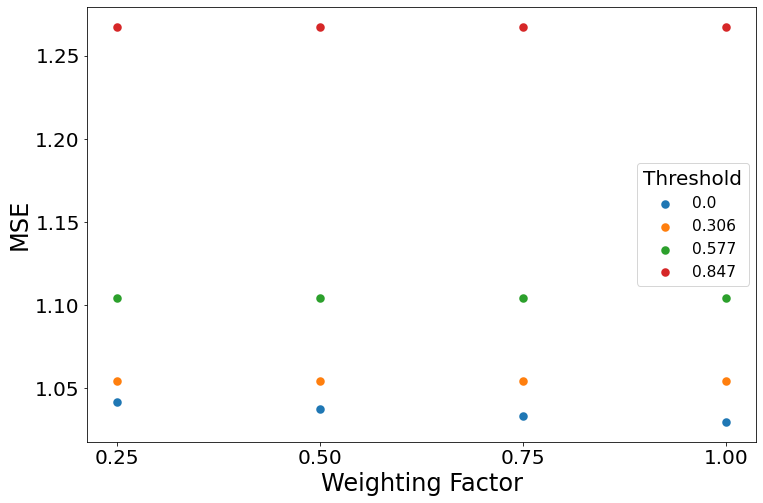

In [31]:
plt.scatter(x = [1,2,3,4], y = threshold_1_hybrid_distance_mse_all_list, label = '0.0', linewidth = 2.5)
plt.scatter(x = [1,2,3,4], y = threshold_2_hybrid_distance_mse_all_list, label = '0.306', linewidth = 2.5)
plt.scatter(x = [1,2,3,4], y = threshold_3_hybrid_distance_mse_all_list, label = '0.577', linewidth = 2.5)
plt.scatter(x = [1,2,3,4], y = threshold_4_hybrid_distance_mse_all_list, label = '0.847', linewidth = 2.5)
plt.xticks(ticks = [1,2,3,4], labels = ['0.25', '0.50', '0.75', '1.00'])
plt.legend(title = 'Threshold')
# plt.yscale('log')
plt.xlabel('Weighting Factor')
plt.ylabel('MSE')
# plt.savefig('../figures/ncf_mse_vs_factors_and_lr.png',bbox_inches='tight')

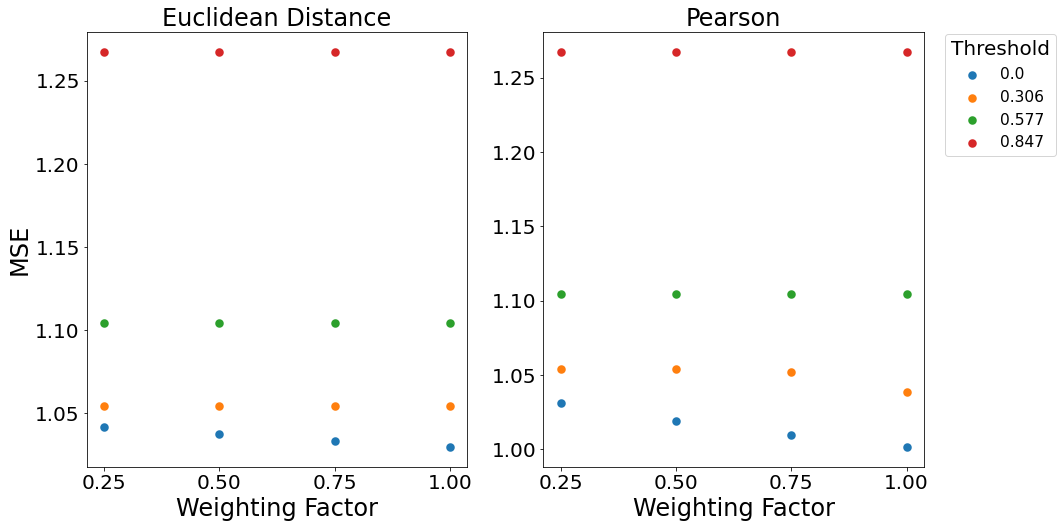

In [32]:
fig, ax = plt.subplots(1,2, figsize=(15, 8), constrained_layout=False,
                        sharex=False)

ax[0].scatter(x = [1,2,3,4], y = threshold_1_hybrid_distance_mse_all_list, label = '0.0', linewidth = 2.5)
ax[0].scatter(x = [1,2,3,4], y = threshold_2_hybrid_distance_mse_all_list, label = '0.306', linewidth = 2.5)
ax[0].scatter(x = [1,2,3,4], y = threshold_3_hybrid_distance_mse_all_list, label = '0.577', linewidth = 2.5)
ax[0].scatter(x = [1,2,3,4], y = threshold_4_hybrid_distance_mse_all_list, label = '0.847', linewidth = 2.5)

ax[1].scatter(x = [1,2,3,4], y = threshold_1_hybrid_pearson_mse_all_list, label = '0.0', linewidth = 2.5)
ax[1].scatter(x = [1,2,3,4], y = threshold_2_hybrid_pearson_mse_all_list, label = '0.306', linewidth = 2.5)
ax[1].scatter(x = [1,2,3,4], y = threshold_3_hybrid_pearson_mse_all_list, label = '0.577', linewidth = 2.5)
ax[1].scatter(x = [1,2,3,4], y = threshold_4_hybrid_pearson_mse_all_list, label = '0.847', linewidth = 2.5)
ax[0].set_ylabel('MSE')
ax[0].set_xlabel('Weighting Factor')
ax[1].set_xlabel('Weighting Factor')
ax[0].set_title('Euclidean Distance')
ax[1].set_title('Pearson')
ax[0].set_xticks(ticks = [1,2,3,4], labels = ['0.25', '0.50', '0.75', '1.00'])
ax[1].set_xticks(ticks = [1,2,3,4], labels = ['0.25', '0.50', '0.75', '1.00'])
handles, labels = ax[1].get_legend_handles_labels()


fig.legend(handles, labels, title = 'Threshold', bbox_to_anchor=(1.03, 0.89))

plt.savefig('figures/hyb_mse_vs_weighting_factor.png',bbox_inches='tight')

# Model Comparison

In [33]:
best_user_distance_mse = 0.761348 # From midterm analysis.ipynb file, with threshold of 0.1, sig_weight of 25
best_user_pearson_mse = 0.769243 # From midterm analysis.ipynb file, with threshold of 0.3, sig_weight of 25
best_item_distance_mse = 0.652500 # From midterm analysis.ipynb file, with threshold of 0.0, sig_weight of 100
best_item_pearson_mse = 0.659491 # From midterm analysis.ipynb file, with threshold of 0.0, sig_weight of 100
best_mf_sgd_mse = 0.91 # from MF homework PDF
best_mf_als_mse = 0.99 # from MF homework PDF
best_tfidf_mse = float(final_result_full_tfidf_df.iloc[[0]]['mse'])
best_hybrid_pearson_mse = float(final_result_full_hybrid_df.iloc[[7]]['mse'])
best_hybrid_distance_mse = float(final_result_full_hybrid_df.iloc[[6]]['mse'])
best_ncf_mse = float(model_info_all_df[model_info_all_df['model'] == 93]['test mse'])

In [34]:
best_user_distance_coverage = 0.904296 # From midterm analysis.ipynb file, with threshold of 0.1, sig_weight of 25
best_user_pearson_coverage = 0.969436 # From midterm analysis.ipynb file, with threshold of 0.3, sig_weight of 25
best_item_distance_coverage = 0.961432 # From midterm analysis.ipynb file, with threshold of 0.0, sig_weight of 100
best_item_pearson_coverage =  0.969657 # From midterm analysis.ipynb file, with threshold of 0.0, sig_weight of 100
best_mf_sgd_coverage = 1 # from MF homework PDF
best_mf_als_coverage = 1 # from MF homework PDF
best_tfidf_coverage = float(final_result_full_tfidf_df.iloc[[0]]['coverage'])
best_hybrid_pearson_coverage = float(final_result_full_hybrid_df.iloc[[7]]['coverage'])
best_hybrid_distance_coverage = float(final_result_full_hybrid_df.iloc[[6]]['coverage'])
best_ncf_coverage = 1

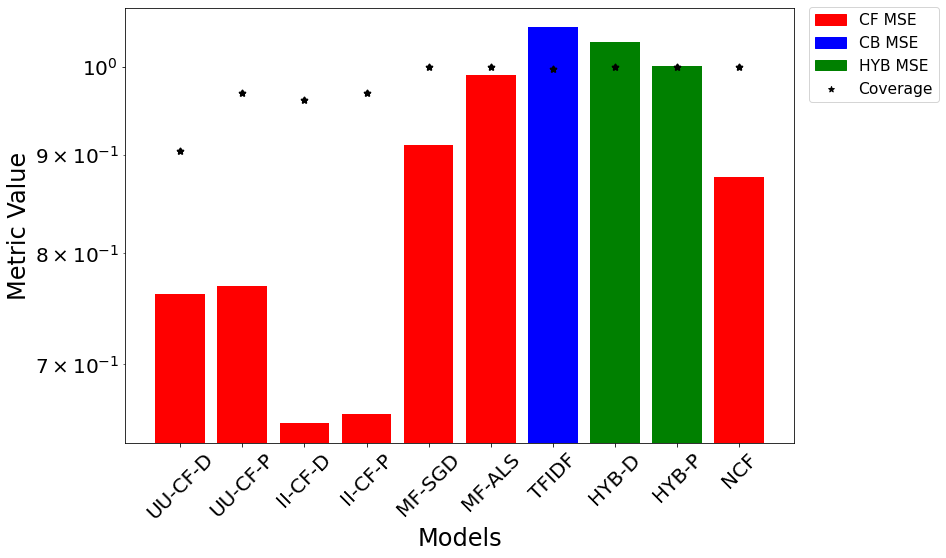

In [36]:
mse_list = [best_user_distance_mse,
               best_user_pearson_mse,
               best_item_distance_mse,
               best_item_pearson_mse,
               best_mf_sgd_mse, 
               best_mf_als_mse, 
               best_tfidf_mse,
               best_hybrid_distance_mse,
               best_hybrid_pearson_mse, 
               best_ncf_mse]

coverage_list = [best_user_distance_coverage,
               best_user_pearson_coverage,
               best_item_distance_coverage,
               best_item_pearson_coverage,
               best_mf_sgd_coverage, 
               best_mf_als_coverage, 
               best_tfidf_coverage,
               best_hybrid_distance_coverage,
               best_hybrid_pearson_coverage, 
               best_ncf_coverage]

model_labels_list = ['UU-CF-D', 'UU-CF-P', 'II-CF-D', 'II-CF-P', 'MF-SGD', 'MF-ALS', 'TFIDF', 'HYB-D', 'HYB-P', 'NCF']
color_list = ['red', 'red', 'red', 'red', 'red', 'red', 'blue', 'green', 'green', 'red']
plt.bar(x = model_labels_list, height = mse_list, color = color_list)
plt.scatter(x = [0,1,2,3,4,5,6,7,8,9], y = coverage_list, color = 'black', zorder = 10, marker = '*', linewidths = 2)
# plt.hlines(xmin=0, xmax=10, y =1, linestyle='dotted')
plt.yscale('log')
plt.xlabel('Models')
plt.ylabel('Metric Value')
plt.xticks(rotation = 45)
handles = [plt.Rectangle((0,0),1,1, color=['red','blue','green'][i]) for i,label in enumerate(['CF','CB', 'HYB'])] + [plt.scatter(0,0, marker = '*', color = 'black',label = 'Coverage')]

plt.legend(handles, ['CF MSE','CB MSE', 'HYB MSE', 'Coverage'], bbox_to_anchor=(1.01, 1.02))
plt.savefig('figures/model_comparison_bar.png',bbox_inches='tight')
